In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import warnings
import sklearn.exceptions
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import matplotlib.pyplot as plt


In [0]:
! kaggle competitions download -c twitter-sentiment-analysis2
!pip install Keras
!pip install --upgrade gensim
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gzip -d GoogleNews-vectors-negative300.bin.gz

  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 124MB/s]
100% 11.0M/11.0M [00:00<00:00, 114MB/s]

     |████████████████████████████████| 24.2MB 1.7MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
--2020-02-25 18:59:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  73.4MB/s    in 20s     

2020-02-25 19:00:04 (77.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
# import the data 
data = pd.read_csv("train.csv.zip",encoding = "ISO-8859-1",index_col = 0)

In [0]:
# tokenize which removes handles(@name) reduces the lenght of repetitive letters and lower case the comments
tknzr = TweetTokenizer(strip_handles=True,reduce_len=True,preserve_case = False)
data["tokenized"] = [tknzr.tokenize(data.iloc[i].SentimentText) for i in range(len(data))]

In [0]:
# download google news corpus
filename = 'GoogleNews-vectors-negative300.bin'
# load pre-trained word2vec model of google news
word_vectors = KeyedVectors.load_word2vec_format(filename, binary=True)

In [0]:
# initialize an array to store the centroids of sentences
t = []
# initialize an array to store the indexes of empty sentences or the sentences without pre trained word embeding
empty = []
# itterate over sentences
for i in range(len(data)):
  d = []
  # itterate over words in sentence
  counter = 0
  for j in range(len(data.tokenized.iloc[i])):
    try :
      # store the word2vec embeding of every word in our coprus
            d.append(word_vectors[data.tokenized.iloc[i][j]])
            counter += 1
    except:
      # if a word of our corpus does not exist store it as "Unk"
            # d.append(word_vectors["Unk"])
            # counter += 1
            pass
  if counter != 0:
          t.append(np.asarray(np.sum(d,axis=0)) / counter)
  else:
      empty.append(i)

In [0]:
# split the dataset into train and test set in ratio 9/1
x_train, x_test, y_train, y_test = train_test_split(t, data.drop(data.index[empty]).Sentiment, test_size=0.1, random_state=8888)

In [0]:
# use the majority model as a classifier. It assigns all the comments in the most frequent class.
base = DummyClassifier(strategy='most_frequent')
# train dummy classifier
base.fit(x_train, y_train)
# predict 
predictions_dummy = base.predict(x_train)
print("Classification report for classifier %s:\n%s\n"%(base, metrics.classification_report(y_train, predictions_dummy)))
predictions_dummy_test = base.predict(x_test)
print("Classification report for classifier %s:\n%s\n"%(base, metrics.classification_report(y_test, predictions_dummy_test)))

Classification report for classifier DummyClassifier(constant=None, random_state=None, strategy='most_frequent'):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     38913
           1       0.56      1.00      0.72     50377

    accuracy                           0.56     89290
   macro avg       0.28      0.50      0.36     89290
weighted avg       0.32      0.56      0.41     89290


Classification report for classifier DummyClassifier(constant=None, random_state=None, strategy='most_frequent'):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4337
           1       0.56      1.00      0.72      5585

    accuracy                           0.56      9922
   macro avg       0.28      0.50      0.36      9922
weighted avg       0.32      0.56      0.41      9922




In [0]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [0]:
# build mlp model to tune the hyperparameters
def create_model(optimizer="adam", dropout=0.1, dense_nparams=256,activation="relu"):
    model = Sequential()
    model.add(Dense(dense_nparams, activation=activation, input_dim=300)) 
    model.add(Dropout(dropout), )
    model.add(Dense(256,  activation = activation))
    model.add(Dropout(dropout), )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[f1])
    return model

In [0]:
mymodel = KerasClassifier(build_fn=create_model, verbose=1)
# create a pipeline of the hyperparameter
lr_pipeline = Pipeline([
    ('kc', mymodel)])
grid_params = {
    'kc__epochs': [19],
    'kc__dense_nparams': [512,700],
    'kc__dropout': [0.6,0.5,],
    'kc__batch_size':[128,64,32],
    'kc__activation':['relu', 'tanh'],
}

In [0]:
# random grid search 
clf2 = RandomizedSearchCV(lr_pipeline, grid_params,scoring='neg_log_loss',cv=3)
clf2.fit(np.array(x_train),np.array(y_train))
print("Best Score: ", clf2.best_score_)
print("Best Params: ", clf2.best_params_)

Epoch 1/19
59526/59526 [==============================] - 10s 173us/step - loss: 0.5645 - f1: 0.7389
Epoch 2/19
59526/59526 [==============================] - 9s 146us/step - loss: 0.5441 - f1: 0.7524
Epoch 3/19
59526/59526 [==============================] - 9s 147us/step - loss: 0.5408 - f1: 0.7525
Epoch 4/19
59526/59526 [==============================] - 9s 149us/step - loss: 0.5384 - f1: 0.7515
Epoch 5/19
59526/59526 [==============================] - 9s 149us/step - loss: 0.5349 - f1: 0.7544
Epoch 6/19
59526/59526 [==============================] - 9s 148us/step - loss: 0.5331 - f1: 0.7556
Epoch 7/19
59526/59526 [==============================] - 9s 149us/step - loss: 0.5330 - f1: 0.7535
Epoch 8/19
59526/59526 [==============================] - 9s 148us/step - loss: 0.5308 - f1: 0.7549
Epoch 9/19
59526/59526 [==============================] - 9s 147us/step - loss: 0.5296 - f1: 0.7547
Epoch 10/19
59526/59526 [==============================] - 9s 149us/step - loss: 0.5289 - f1: 0.757

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 6s 107us/step - loss: 0.5597 - f1: 0.7454
Epoch 2/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5331 - f1: 0.7636
Epoch 3/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.5247 - f1: 0.7670
Epoch 4/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5191 - f1: 0.7734
Epoch 5/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5115 - f1: 0.7756
Epoch 6/19
59527/59527 [==============================] - 5s 81us/step - loss: 0.5073 - f1: nan
Epoch 7/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5028 - f1: 0.7814
Epoch 8/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4987 - f1: 0.7837
Epoch 9/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4927 - f1: 0.7873
Epoch 10/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.4903 - f1: 0.7869
Epoch 11/19

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 6s 108us/step - loss: 0.5605 - f1: 0.7431
Epoch 2/19
59527/59527 [==============================] - 4s 74us/step - loss: 0.5345 - f1: 0.7599
Epoch 3/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5260 - f1: 0.7643
Epoch 4/19
59527/59527 [==============================] - 4s 76us/step - loss: 0.5196 - f1: 0.7682
Epoch 5/19
59527/59527 [==============================] - 5s 79us/step - loss: 0.5148 - f1: 0.7698
Epoch 6/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.5080 - f1: 0.7751
Epoch 7/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5055 - f1: 0.7768
Epoch 8/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5003 - f1: 0.7797
Epoch 9/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.4946 - f1: 0.7829
Epoch 10/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.4919 - f1: 0.7853
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59526/59526 [==============================] - 6s 108us/step - loss: 0.5538 - f1: 0.7478
Epoch 2/19
59526/59526 [==============================] - 4s 76us/step - loss: 0.5280 - f1: 0.7615
Epoch 3/19
59526/59526 [==============================] - 5s 78us/step - loss: 0.5178 - f1: 0.7704
Epoch 4/19
59526/59526 [==============================] - 5s 78us/step - loss: 0.5112 - f1: 0.7710
Epoch 5/19
59526/59526 [==============================] - 5s 79us/step - loss: 0.5033 - f1: 0.7757
Epoch 6/19
59526/59526 [==============================] - 5s 79us/step - loss: 0.4977 - f1: 0.7797
Epoch 7/19
59526/59526 [==============================] - 4s 75us/step - loss: 0.4913 - f1: 0.7835
Epoch 8/19
59526/59526 [==============================] - 5s 77us/step - loss: 0.4861 - f1: 0.7877
Epoch 9/19
59526/59526 [==============================] - 5s 78us/step - loss: 0.4790 - f1: 0.7909
Epoch 10/19
59526/59526 [==============================] - 4s 75us/step - loss: 0.4748 - f1: 0.7924
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 112us/step - loss: 0.5528 - f1: 0.7496
Epoch 2/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5280 - f1: 0.7668
Epoch 3/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5189 - f1: 0.7721
Epoch 4/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5100 - f1: 0.7758
Epoch 5/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.5033 - f1: 0.7802
Epoch 6/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4973 - f1: 0.7821
Epoch 7/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.4909 - f1: 0.7879
Epoch 8/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.4848 - f1: 0.7885
Epoch 9/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4786 - f1: 0.7925
Epoch 10/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.4736 - f1: 0.7952
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 114us/step - loss: 0.5538 - f1: nan
Epoch 2/19
59527/59527 [==============================] - 4s 76us/step - loss: 0.5297 - f1: 0.7626
Epoch 3/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5193 - f1: 0.7683
Epoch 4/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5116 - f1: 0.7722
Epoch 5/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.5036 - f1: 0.7766
Epoch 6/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.4991 - f1: 0.7789
Epoch 7/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4933 - f1: 0.7813
Epoch 8/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.4867 - f1: 0.7852
Epoch 9/19
59527/59527 [==============================] - 5s 78us/step - loss: 0.4815 - f1: 0.7880
Epoch 10/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.4755 - f1: 0.7927
Epoch 11/19

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59526/59526 [==============================] - 7s 114us/step - loss: 0.5628 - f1: nan
Epoch 2/19
59526/59526 [==============================] - 4s 74us/step - loss: 0.5340 - f1: 0.7592
Epoch 3/19
59526/59526 [==============================] - 4s 75us/step - loss: 0.5261 - f1: 0.7650
Epoch 4/19
59526/59526 [==============================] - 5s 76us/step - loss: 0.5199 - f1: 0.7684
Epoch 5/19
59526/59526 [==============================] - 5s 81us/step - loss: 0.5128 - f1: 0.7707
Epoch 6/19
59526/59526 [==============================] - 5s 76us/step - loss: 0.5088 - f1: 0.7739
Epoch 7/19
59526/59526 [==============================] - 4s 74us/step - loss: 0.5049 - f1: 0.7764
Epoch 8/19
59526/59526 [==============================] - 4s 73us/step - loss: 0.5007 - f1: 0.7791
Epoch 9/19
59526/59526 [==============================] - 4s 75us/step - loss: 0.4944 - f1: 0.7832
Epoch 10/19
59526/59526 [==============================] - 4s 76us/step - loss: 0.4928 - f1: 0.7847
Epoch 11/19

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 114us/step - loss: 0.5604 - f1: 0.7444
Epoch 2/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5341 - f1: 0.7628
Epoch 3/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5256 - f1: 0.7680
Epoch 4/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5193 - f1: 0.7725
Epoch 5/19
59527/59527 [==============================] - 5s 79us/step - loss: 0.5136 - f1: nan
Epoch 6/19
59527/59527 [==============================] - 5s 81us/step - loss: 0.5088 - f1: 0.7767
Epoch 7/19
59527/59527 [==============================] - 5s 80us/step - loss: 0.5046 - f1: 0.7808
Epoch 8/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5000 - f1: 0.7831
Epoch 9/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4948 - f1: 0.7849
Epoch 10/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.4900 - f1: 0.7870
Epoch 11/19

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 117us/step - loss: 0.5616 - f1: 0.7429
Epoch 2/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5347 - f1: 0.7595
Epoch 3/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5260 - f1: 0.7645
Epoch 4/19
59527/59527 [==============================] - 5s 77us/step - loss: 0.5205 - f1: 0.7677
Epoch 5/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5146 - f1: 0.7719
Epoch 6/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5098 - f1: 0.7742
Epoch 7/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.5058 - f1: 0.7760
Epoch 8/19
59527/59527 [==============================] - 5s 76us/step - loss: 0.5008 - f1: 0.7799
Epoch 9/19
59527/59527 [==============================] - 4s 74us/step - loss: 0.4962 - f1: 0.7806
Epoch 10/19
59527/59527 [==============================] - 4s 75us/step - loss: 0.4926 - f1: 0.7840
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59526/59526 [==============================] - 12s 197us/step - loss: 0.5587 - f1: 0.7427
Epoch 2/19
59526/59526 [==============================] - 9s 153us/step - loss: 0.5405 - f1: 0.7525
Epoch 3/19
59526/59526 [==============================] - 9s 153us/step - loss: 0.5372 - f1: 0.7541
Epoch 4/19
59526/59526 [==============================] - 9s 150us/step - loss: 0.5345 - f1: 0.7531
Epoch 5/19
59526/59526 [==============================] - 9s 151us/step - loss: 0.5309 - f1: 0.7546
Epoch 6/19
59526/59526 [==============================] - 9s 154us/step - loss: 0.5290 - f1: 0.7545
Epoch 7/19
59526/59526 [==============================] - 9s 156us/step - loss: 0.5260 - f1: 0.7565
Epoch 8/19
59526/59526 [==============================] - 9s 150us/step - loss: 0.5250 - f1: 0.7587
Epoch 9/19
59526/59526 [==============================] - 9s 155us/step - loss: 0.5231 - f1: 0.7595
Epoch 10/19
59526/59526 [==============================] - 9s 151us/step - loss: 0.5224 - f1: 0.762

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 13s 223us/step - loss: 0.5544 - f1: 0.7452
Epoch 2/19
59527/59527 [==============================] - 10s 166us/step - loss: 0.5296 - f1: 0.7644
Epoch 3/19
59527/59527 [==============================] - 10s 165us/step - loss: 0.5205 - f1: 0.7679
Epoch 4/19
59527/59527 [==============================] - 10s 167us/step - loss: 0.5138 - f1: 0.7727
Epoch 5/19
59527/59527 [==============================] - 10s 164us/step - loss: 0.5079 - f1: 0.7728
Epoch 6/19
59527/59527 [==============================] - 10s 164us/step - loss: 0.5028 - f1: 0.7793
Epoch 7/19
59527/59527 [==============================] - 10s 164us/step - loss: 0.4966 - f1: 0.7803
Epoch 8/19
59527/59527 [==============================] - 10s 168us/step - loss: 0.4902 - f1: 0.7846
Epoch 9/19
59527/59527 [==============================] - 10s 167us/step - loss: 0.4853 - f1: 0.7885
Epoch 10/19
59527/59527 [==============================] - 10s 162us/step - loss: 0.4800 - 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 13s 226us/step - loss: 0.5555 - f1: 0.7431
Epoch 2/19
59527/59527 [==============================] - 10s 164us/step - loss: 0.5297 - f1: 0.7577
Epoch 3/19
59527/59527 [==============================] - 10s 165us/step - loss: 0.5220 - f1: 0.7637
Epoch 4/19
59527/59527 [==============================] - 10s 166us/step - loss: 0.5126 - f1: 0.7704
Epoch 5/19
59527/59527 [==============================] - 10s 161us/step - loss: 0.5075 - f1: 0.7716
Epoch 6/19
59527/59527 [==============================] - 10s 165us/step - loss: 0.5017 - f1: 0.7761
Epoch 7/19
59527/59527 [==============================] - 10s 168us/step - loss: 0.4956 - f1: 0.7796
Epoch 8/19
59527/59527 [==============================] - 10s 163us/step - loss: 0.4912 - f1: 0.7804
Epoch 9/19
59527/59527 [==============================] - 10s 161us/step - loss: 0.4857 - f1: 0.7866
Epoch 10/19
59527/59527 [==============================] - 10s 167us/step - loss: 0.4794 - 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59526/59526 [==============================] - 8s 139us/step - loss: 0.5604 - f1: 0.7461
Epoch 2/19
59526/59526 [==============================] - 5s 82us/step - loss: 0.5403 - f1: 0.7600
Epoch 3/19
59526/59526 [==============================] - 5s 83us/step - loss: 0.5369 - f1: 0.7607
Epoch 4/19
59526/59526 [==============================] - 5s 82us/step - loss: 0.5339 - f1: 0.7579
Epoch 5/19
59526/59526 [==============================] - 5s 83us/step - loss: 0.5314 - f1: 0.7591
Epoch 6/19
59526/59526 [==============================] - 5s 82us/step - loss: 0.5297 - f1: 0.7583
Epoch 7/19
59526/59526 [==============================] - 5s 81us/step - loss: 0.5291 - f1: 0.7592
Epoch 8/19
59526/59526 [==============================] - 5s 82us/step - loss: 0.5267 - f1: 0.7602
Epoch 9/19
59526/59526 [==============================] - 5s 83us/step - loss: 0.5238 - f1: 0.7617
Epoch 10/19
59526/59526 [==============================] - 5s 83us/step - loss: 0.5230 - f1: 0.7631
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 9s 152us/step - loss: 0.5534 - f1: 0.7490
Epoch 2/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.5270 - f1: 0.7651
Epoch 3/19
59527/59527 [==============================] - 5s 89us/step - loss: 0.5179 - f1: 0.7724
Epoch 4/19
59527/59527 [==============================] - 5s 87us/step - loss: 0.5106 - f1: 0.7752
Epoch 5/19
59527/59527 [==============================] - 5s 84us/step - loss: 0.5056 - f1: 0.7782
Epoch 6/19
59527/59527 [==============================] - 5s 84us/step - loss: 0.4988 - f1: 0.7827
Epoch 7/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4918 - f1: 0.7848
Epoch 8/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4874 - f1: 0.7876
Epoch 9/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4808 - f1: 0.7927
Epoch 10/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4749 - f1: 0.7958
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 9s 156us/step - loss: 0.5555 - f1: 0.7459
Epoch 2/19
59527/59527 [==============================] - 5s 86us/step - loss: 0.5276 - f1: 0.7624
Epoch 3/19
59527/59527 [==============================] - 5s 86us/step - loss: 0.5197 - f1: 0.7679
Epoch 4/19
59527/59527 [==============================] - 5s 86us/step - loss: 0.5113 - f1: 0.7720
Epoch 5/19
59527/59527 [==============================] - 5s 87us/step - loss: 0.5062 - f1: 0.7779
Epoch 6/19
59527/59527 [==============================] - 5s 87us/step - loss: 0.5006 - f1: 0.7787
Epoch 7/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4922 - f1: 0.7829
Epoch 8/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4874 - f1: 0.7856
Epoch 9/19
59527/59527 [==============================] - 5s 85us/step - loss: 0.4826 - f1: 0.7874
Epoch 10/19
59527/59527 [==============================] - 5s 84us/step - loss: 0.4768 - f1: 0.7922
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59526/59526 [==============================] - 7s 114us/step - loss: 0.5558 - f1: 0.7474
Epoch 2/19
59526/59526 [==============================] - 3s 42us/step - loss: 0.5276 - f1: 0.7631
Epoch 3/19
59526/59526 [==============================] - 3s 43us/step - loss: 0.5169 - f1: 0.7700
Epoch 4/19
59526/59526 [==============================] - 3s 43us/step - loss: 0.5088 - f1: 0.7742
Epoch 5/19
59526/59526 [==============================] - 3s 42us/step - loss: 0.5033 - f1: 0.7783
Epoch 6/19
59526/59526 [==============================] - 3s 43us/step - loss: 0.4984 - f1: 0.7830
Epoch 7/19
59526/59526 [==============================] - 3s 43us/step - loss: 0.4899 - f1: 0.7846
Epoch 8/19
59526/59526 [==============================] - 3s 43us/step - loss: 0.4823 - f1: 0.7900
Epoch 9/19
59526/59526 [==============================] - 2s 42us/step - loss: 0.4792 - f1: 0.7901
Epoch 10/19
59526/59526 [==============================] - 3s 42us/step - loss: 0.4726 - f1: 0.7949
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 113us/step - loss: 0.5538 - f1: 0.7519
Epoch 2/19
59527/59527 [==============================] - 3s 42us/step - loss: 0.5264 - f1: 0.7682
Epoch 3/19
59527/59527 [==============================] - 2s 42us/step - loss: 0.5168 - f1: 0.7740
Epoch 4/19
59527/59527 [==============================] - 3s 42us/step - loss: 0.5094 - f1: 0.7755
Epoch 5/19
59527/59527 [==============================] - 3s 43us/step - loss: 0.5025 - f1: 0.7822
Epoch 6/19
59527/59527 [==============================] - 3s 43us/step - loss: 0.4952 - f1: 0.7848
Epoch 7/19
59527/59527 [==============================] - 3s 43us/step - loss: 0.4895 - f1: 0.7876
Epoch 8/19
59527/59527 [==============================] - 3s 43us/step - loss: 0.4839 - f1: 0.7922
Epoch 9/19
59527/59527 [==============================] - 3s 42us/step - loss: 0.4786 - f1: 0.7934
Epoch 10/19
59527/59527 [==============================] - 3s 42us/step - loss: 0.4733 - f1: 0.7975
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
59527/59527 [==============================] - 7s 115us/step - loss: 0.5560 - f1: 0.7469
Epoch 2/19
59527/59527 [==============================] - 3s 44us/step - loss: 0.5265 - f1: 0.7635
Epoch 3/19
59527/59527 [==============================] - 3s 45us/step - loss: 0.5167 - f1: 0.7714
Epoch 4/19
59527/59527 [==============================] - 3s 45us/step - loss: 0.5101 - f1: 0.7734
Epoch 5/19
59527/59527 [==============================] - 3s 45us/step - loss: 0.5028 - f1: 0.7794
Epoch 6/19
59527/59527 [==============================] - 3s 45us/step - loss: 0.4962 - f1: 0.7823
Epoch 7/19
59527/59527 [==============================] - 3s 44us/step - loss: 0.4916 - f1: 0.7837
Epoch 8/19
59527/59527 [==============================] - 3s 44us/step - loss: 0.4857 - f1: 0.7881
Epoch 9/19
59527/59527 [==============================] - 3s 43us/step - loss: 0.4792 - f1: 0.7916
Epoch 10/19
59527/59527 [==============================] - 2s 42us/step - loss: 0.4733 - f1: 0.7934
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


Epoch 1/19
89290/89290 [==============================] - 12s 134us/step - loss: 0.5543 - f1: 0.7502
Epoch 2/19
89290/89290 [==============================] - 8s 84us/step - loss: 0.5379 - f1: 0.7609
Epoch 3/19
89290/89290 [==============================] - 8s 84us/step - loss: 0.5343 - f1: 0.7601
Epoch 4/19
89290/89290 [==============================] - 8s 86us/step - loss: 0.5310 - f1: 0.7600
Epoch 5/19
89290/89290 [==============================] - 8s 85us/step - loss: 0.5277 - f1: 0.7622
Epoch 6/19
89290/89290 [==============================] - 8s 84us/step - loss: 0.5260 - f1: 0.7633
Epoch 7/19
89290/89290 [==============================] - 8s 85us/step - loss: 0.5236 - f1: 0.7645
Epoch 8/19
89290/89290 [==============================] - 8s 86us/step - loss: 0.5225 - f1: 0.7646
Epoch 9/19
89290/89290 [==============================] - 8s 84us/step - loss: 0.5204 - f1: 0.7660
Epoch 10/19
89290/89290 [==============================] - 7s 84us/step - loss: 0.5188 - f1: 0.7671
Epoch 1

In [0]:
clf_logistic = LogisticRegression(solver="liblinear",random_state=8888,C=1)
# train the logistic regression
clf_logistic.fit(x_train, y_train)
# predict in train set
predictions_logistic = clf_logistic.predict(x_train)
print("Classification report for classifier in train %s:\n%s\n"%(clf_logistic, metrics.classification_report(y_train, predictions_logistic)))
# predict for the test set
predictions_test_logistic = clf_logistic.predict(x_test)
print("Classification report for classifier in test %s:\n%s\n"%(clf_logistic, metrics.classification_report(y_test, predictions_test_logistic)))

Classification report for classifier in train LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8888, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       0.72      0.65      0.68     38913
           1       0.75      0.80      0.77     50377

    accuracy                           0.74     89290
   macro avg       0.73      0.73      0.73     89290
weighted avg       0.73      0.74      0.73     89290


Classification report for classifier in test LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8888, solv

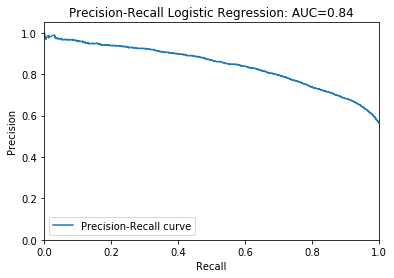

In [0]:
name = 'Logistic Regression'
pred = clf_logistic.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
area = auc(recall, precision)

# plot the AUC curve for logistic regression 
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' %(name,area))
plt.legend(loc="lower left")
plt.show()

In [1]:
model = Sequential()
model.add(Dense(512, input_dim=np.array(x_train).shape[1] , activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(128,  activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1,  activation='sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001), metrics=[precision, recall, f1, accuracy])
# monitor loss in validation set and save the minimum values
checkpoint = ModelCheckpoint('kerasW2vec', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
# monitor loss in validatin set and stop when starting to grow to avoid overfitting
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)
history = model.fit(np.array(x_train),np.array(y_train),
              batch_size=156,
              epochs=100,
              verbose = 1,
              callbacks=[early_stop, checkpoint],
              validation_split = 0.2,
              shuffle=True)

NameError: ignored

In [0]:
# predict neural network in train set
predictions_nn_train = model.predict(np.array(x_train))
# threshold used t=0,5 (round())
print("Classification report for Neural network in train :\n",metrics.classification_report(y_train,np.round(predictions_nn_train)))
# predict neural network in test set
predictions_nn_test = model.predict(np.array(x_test))
# threshold used t=0,5 (round())
print("Classification report for Neural network in test :\n",metrics.classification_report(y_test,np.round(predictions_nn_test)))

Classification report for Neural network in train :
               precision    recall  f1-score   support

           0       0.73      0.70      0.72     38913
           1       0.78      0.80      0.79     50377

    accuracy                           0.76     89290
   macro avg       0.75      0.75      0.75     89290
weighted avg       0.76      0.76      0.76     89290

Classification report for Neural network in test :
               precision    recall  f1-score   support

           0       0.72      0.68      0.70      4337
           1       0.76      0.80      0.78      5585

    accuracy                           0.75      9922
   macro avg       0.74      0.74      0.74      9922
weighted avg       0.75      0.75      0.75      9922



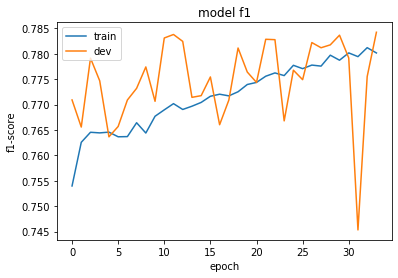

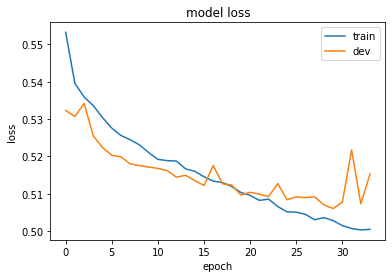

In [0]:
# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

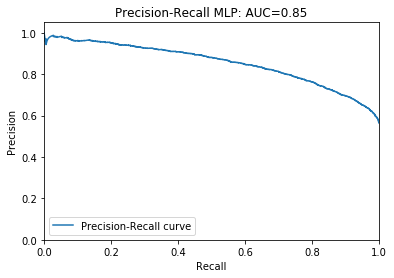

In [0]:
name ="MLP"
# compute precesion,recall for various thresholds
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, predictions_nn_test)
# compute the area under curve
area_nn = auc(recall_nn, precision_nn)


# plot the AUC curve for MLP
plt.plot(recall_nn, precision_nn, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' %(name,area_nn))
plt.legend(loc="lower left")
plt.show()

In [0]:
# H0 NN perfoms as good as Logistic regression : F1_NN = F1_logistic
# H1 NN performs better than Logistic regression : F1_NN > F1_logistic

# n: lenght of test set
n = np.array(x_test).shape[0]
# b: samples draws
b = 1000
# the difference between F1 score of MLP and logistic regression
delta = f1_score(y_test,np.round(predictions_nn_test),average="macro") - f1_score(y_test,predictions_test_logistic,average="macro")
count = 0
for i in range(b):
  # draw random samples with replacement from the test sets  
    x,y = resample(np.array(x_test),np.array(y_test), n_samples=n)
    # in the random test sets predict the models
    NN = model.predict(x)
    logistic = clf_logistic.predict(x)
    # compute the difference in f1 scores in the random test samples
    diff = f1_score(np.round(NN),y,average="macro") - f1_score(logistic,y,average="macro")
    if diff > 2*delta:
            count += 1
p_value = count/b
if p_value < 0.01:
    print("NN performs better than Logistic regression")
    print("p-value:",p_value)
else:
    print("NN performs as good as Logistic regression")
    print("p-value:",p_value)

NN performs better than Logistic regression
p-value: 0.0
